In [1]:
!pip install sentencepiece
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer,Dense,Dropout
import stanza
import sentencepiece as spm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import re
import sentencepiece as spm

# File paths
eng_sentences_path_q='/kaggle/input/eng-uda/quran/Quran-EN'
urdu_sentences_path_q='/kaggle/input/eng-uda/quran/Quran-UR-normalized'


# Function to load and clean sentences
def load_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

# Cleaning and adding tokens to English sentences
def clean_text_eng(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove unwanted characters
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra spaces
    return "<start> " + text + " <end>"

# Cleaning, reversing, and adding tokens to Urdu sentences
def clean_text_urdu(text):
    text = text.lower()
    text = re.sub(r"[^ء-ی\s]", "", text)       # Remove unwanted characters
    text = re.sub(r"\s+", " ", text).strip()  # Reverse word order
    return "<start> " + text + " <end>"

def clean_text_train_l(text):
    text = text.lower()
    text = re.sub(r"[^ء-ی\s]", "", text)       # Remove unwanted characters
    text = re.sub(r"\s+", " ", text).strip()   # Remove extra spaces
    return "<start> " + text

# Load and clean sentences for both languages
eng_sentences = load_sentences(eng_sentences_path_q)
urdu_sentences = load_sentences(urdu_sentences_path_q)

eng_sentences = [clean_text_eng(sentence) for sentence in eng_sentences]
urdu_sentences = [clean_text_urdu(sentence) for sentence in urdu_sentences]
urdu_sentences_train = [clean_text_train_l(sentence) for sentence in urdu_sentences]


# Ensure both files have the same number of lines
assert len(eng_sentences) == len(urdu_sentences), "Mismatch in number of sentences."

# Save cleaned sentences to text files
with open("eng_sentences.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(eng_sentences))

with open("urdu_sentences.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(urdu_sentences))

# Function to calculate dynamic vocabulary size
def calculate_vocab_size(sentences):
    all_tokens = set(token for sentence in sentences for token in sentence.split())
    return int(len(all_tokens) * 1.1)  # Add 10% buffer for unseen tokens

# Calculate vocabulary sizes
eng_vocab_size = calculate_vocab_size(eng_sentences)
urdu_vocab_size = calculate_vocab_size(urdu_sentences)

print(f"Dynamic English vocab size: {eng_vocab_size}")
print(f"Dynamic Urdu vocab size: {urdu_vocab_size}")

# Train BPE models with special tokens
spm.SentencePieceTrainer.train(
    input="eng_sentences.txt",
    model_prefix="eng_bpe",
    vocab_size=eng_vocab_size,
    model_type="bpe",
    unk_piece="<unk>",
    user_defined_symbols=["<start>", "<end>"]
)


spm.SentencePieceTrainer.train(
    input="urdu_sentences.txt",
    model_prefix="urdu_bpe",
    vocab_size=urdu_vocab_size,
    model_type="bpe",
    unk_piece="<unk>",
    user_defined_symbols=["<start>", "<end>"]
)

# Load trained SentencePiece models
sp_eng = spm.SentencePieceProcessor(model_file="eng_bpe.model")
sp_urdu = spm.SentencePieceProcessor(model_file="urdu_bpe.model")

# Example tokenization
sample_eng = "<start> This is a test sentence. <end>"
sample_urdu = "<start> یہ ایک آزمائشی جملہ ہے۔ <end>"

print("English tokens:", sp_eng.encode(sample_eng, out_type=str))
print("Urdu tokens:", sp_urdu.encode(sample_urdu, out_type=str))

Dynamic English vocab size: 8933
Dynamic Urdu vocab size: 7771
English tokens: ['▁', '<start>', '▁', 'T', 'hi', 's', '▁is', '▁a', '▁test', '▁sentence', '.', '▁', '<end>']
Urdu tokens: ['▁', '<start>', '▁یہ', '▁ایک', '▁آزمائ', 'شی', '▁جملہ', '▁ہ', 'ے۔', '▁', '<end>']


In [5]:
def tokens_to_ids_urd(tokens):
    return [sp_urdu.piece_to_id(token) for token in tokens]

def tokens_to_ids_eng(tokens):
    return [sp_eng.piece_to_id(token) for token in tokens]
    
def process_sentences(src_sentences, target_sentences, max_tokens):
    src_tokenized = [sp_eng.encode_as_pieces(eng) for eng in src_sentences]  # English (source)
    target_tokenized = [sp_urdu.encode_as_pieces(urdu) for urdu in target_sentences]  # Urdu (target)
    src_ids = [tokens_to_ids_eng(sentence) for sentence in src_tokenized]
    target_ids = [tokens_to_ids_urd(sentence) for sentence in target_tokenized]
    src_ragged = tf.ragged.constant(src_ids, dtype=tf.int32)
    target_ragged = tf.ragged.constant(target_ids, dtype=tf.int32)
    src_ragged = src_ragged[:, :max_tokens]
    target_ragged = target_ragged[:, :max_tokens]
    inputs = src_ragged
    labels = target_ragged

    # Pad sequences to ensure they are of the same length
    inputs_padded = inputs.to_tensor(default_value=0, shape=[None, max_tokens])
    labels_padded = labels.to_tensor(default_value=0, shape=[None, max_tokens])
    return inputs_padded,labels_padded

In [6]:
max_tokens = 100  # You can adjust the max number of tokens based on your requirements

inputs, labels = process_sentences(eng_sentences, urdu_sentences, max_tokens)
inputsxx, labels_train = process_sentences(eng_sentences, urdu_sentences_train, max_tokens) #for this i will only use labels_train as it has no <end> tag while labels has <end> tag

print(inputs[0])
print(labels_train[0])

tf.Tensor(
[8907    3   40 1042   39   35   56  317    8 2326   28   40    8 1136
 8907    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32)
tf.Tensor(
[7730    3  152 1688   59   88    6   73   42   52  505 1003   20 2240
  361  112    7    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0

In [7]:
print(len(labels))
print(len(labels))


6414
6414


In [8]:
def detokenize_with_masking_urdu(tokens):
    # Remove padding tokens (assuming padding token is 0)
    tokens = [token for token in tokens if token != 0]
    return sp_urdu.decode_ids(tokens)
def detokenize_with_masking_eng(tokens):
    # Remove padding tokens (assuming padding token is 0)
    tokens = [token for token in tokens if token != 0]
    return sp_eng.decode_ids(tokens)

In [9]:
detokenized_input = detokenize_with_masking_eng(inputs[0].numpy().tolist())
detokenized_label = detokenize_with_masking_urdu(labels[0].numpy().tolist())

print(labels[0])

print("Detokenized Input (English):", detokenized_input)
print("Detokenized Label (Urdu):", detokenized_label)

tf.Tensor(
[7730    3  152 1688   59   88    6   73   42   52  505 1003   20 2240
  361  112    7 7730    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32)
Detokenized Input (English): <start> all praise be to allah alone the sustainer of all the worlds <end>
Detokenized Label (Urdu): <start> سب تعریفیں اللہ ہی ک لئ ہیں جو تمام جہانوں کی پرورش فرمان والا ہ <end>


In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Ensure inputs are correctly structured as arrays
inputs_0 = inputs.numpy()  # Convert to numpy arrays
inputs_1 = labels_train.numpy()  # Convert to numpy arrays

# Split the data into training and validation sets (split inputs and labels separately)
train_inputs_0, val_inputs_0, train_inputs_1, val_inputs_1, train_labels, val_labels = train_test_split(
    inputs_0, inputs_1, labels.numpy(), test_size=0.1, random_state=42
)

# Ensure train_labels and val_labels have the correct shape
train_labels = tf.reshape(train_labels, (train_labels.shape[0], -1))  # Reshape to [batch_size, label_dim]
val_labels = tf.reshape(val_labels, (val_labels.shape[0], -1))

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_inputs_0, train_inputs_1), train_labels)  # Unpack the tuple properly for multiple inputs
)

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    ((val_inputs_0, val_inputs_1), val_labels)  # Unpack the tuple properly for multiple inputs
)

# Shuffle and batch the training data
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32, drop_remainder=True)

# Batch the validation data without shuffling
val_dataset = val_dataset.batch(32)


In [11]:

for data, label in train_dataset.take(1):  # Take one batch
    print("Data (inputs):", data)
    print("Label:", label)
    print("x shape:", data[0].shape)  # First input (x)
    print("y shape:", data[1].shape)  # Second input (y)
    print("Label shape:", label.shape)  # Label shape

Data (inputs): (<tf.Tensor: shape=(32, 100), dtype=int32, numpy=
array([[8907,    3,   50, ...,    0,    0,    0],
       [8907,    3, 1060, ...,    0,    0,    0],
       [8907,    3,   31, ...,    0,    0,    0],
       ...,
       [8907,    3,   89, ...,  523,  310,   50],
       [8907,    3,   15, ...,    0,    0,    0],
       [8907,    3, 2234, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(32, 100), dtype=int32, numpy=
array([[7730,    3,  255, ...,    0,    0,    0],
       [7730,    3,  503, ...,    0,    0,    0],
       [7730,    3,   32, ...,    0,    0,    0],
       ...,
       [7730,    3,  340, ...,  105,  205, 1838],
       [7730,    3,   15, ...,    0,    0,    0],
       [7730,    3, 1226, ...,    0,    0,    0]], dtype=int32)>)
Label: tf.Tensor(
[[7730    3  255 ...    0    0    0]
 [7730    3  503 ...    0    0    0]
 [7730    3   32 ...    0    0    0]
 ...
 [7730    3  340 ...  105  205 1838]
 [7730    3   15 ...    0    0    0]
 [7730    3 1226 ...  

In [12]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

**Maksanknjasdn**

In [13]:
def get_positional_encoding(seq_len, model_dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(model_dim)[np.newaxis, :]
    
    angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(model_dim))
    
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
class Pos_emb(Layer):
    def __init__(self,v_s,dim):
        super().__init__()
        self.embedding=tf.keras.layers.Embedding(v_s,dim,mask_zero=True)
        self.pos_encoding=get_positional_encoding(100,dim)

    def call(self,input):
        temp=self.embedding(input)
        seq_len=tf.shape(input)[1]
        temp=temp+self.pos_encoding[:seq_len,:]
        return temp

In [15]:
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        # Depth of each attention head
        self.depth = d_model // self.num_heads

        # Separate weight matrices for Q, K, V with L2 regularization
        self.wq = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(0.0001))  # L2 Regularization
        self.wk = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(0.0001))  # L2 Regularization
        self.wv = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(0.0001))  # L2 Regularization

        # Final dense layer to output
        self.dense = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(0.0001))

    def split_heads(self, x, batch_size):
        """ Split the last dimension into (num_heads, depth)."""
        # x.shape -> (batch_size, seq_len, d_model)
        # return shape -> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def attention(self, q, k, v, mask=None):
        """ Scaled Dot-Product Attention """
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        
        # Scale by the square root of depth
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        # Masking (optional)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (batch_size, num_heads, seq_len, seq_len)

        # Output
        output = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)
        return output, attention_weights

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]

        # Linear projections for Q, K, V
        q = self.wq(query)  # (batch_size, seq_len_q, d_model)
        k = self.wk(key)    # (batch_size, seq_len_k, d_model)
        v = self.wv(value)  # (batch_size, seq_len_v, d_model)

        # Split into multiple heads
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Apply attention
        output, attention_weights = self.attention(q, k, v, mask)

        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        output = tf.reshape(output, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # Final linear projection
        output = self.dense(output)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [16]:
class Attention(Layer):
    def __init__(self, num_heads, dim):
        super().__init__()
        # Initialize the custom MultiHeadAttention layer and other components
        self.multi_base = MultiHeadAttention(num_heads, dim)
        self.norm_ = tf.keras.layers.LayerNormalization()
        self.add_ = tf.keras.layers.Add()

    def call(self, query, input, mask=None):
        # Perform the multi-head attention
        attention_out, _ = self.multi_base(query=query, key=input, value=input, mask=mask)
        # Add the input and attention output, followed by normalization
        temp = self.add_([input, attention_out])
        return self.norm_(temp)

class CrossAttention(Attention):
    def __init__(self, **kwargs):
        # Call the parent class initializer
        super().__init__(**kwargs)

    def call(self, query, input):
        # Perform the multi-head attention
        attention_out, _ = self.multi_base(query=query, key=input, value=input,mask=None)
        # Add the input and attention output, followed by normalization
        temp = self.add_([input, attention_out])
        return self.norm_(temp)
class SelfAttention(Attention):
    def __init__(self, **kwargs):
        # Call the parent class initializer
        super().__init__(**kwargs)

    def call(self, input):
        # Perform the multi-head attention
        attention_out, _ = self.multi_base(query=input, key=input, value=input,mask=None)
        # Add the input and attention output, followed by normalization
        temp = self.add_([input, attention_out])
        return self.norm_(temp)
class MaskedAttention(Attention):
    def __init__(self, use_causal_mask=False, **kwargs):
        # Call the parent class initializer
        super().__init__(**kwargs)
        self.use_causal_mask = use_causal_mask

    def create_causal_mask(self, size):
        """ Create a causal mask to prevent attending to future positions. """
        mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

    def call(self, input):
        seq_len = tf.shape(input)[1]  # Assuming query and input have the same length
        mask = None
        
        # Generate causal mask if required
        if self.use_causal_mask:
            mask = self.create_causal_mask(seq_len)
            mask = mask[tf.newaxis, tf.newaxis, :, :]  # Add batch and head dimensions

        # Perform the multi-head attention with optional mask
        attention_out, _ = self.multi_base(query=input, key=input, value=input, mask=mask)

        # Add the input and attention output, followed by normalization
        temp = self.add_([input, attention_out])
        return self.norm_(temp)

In [17]:
class FeedForward(Layer):
    def __init__(self,drate):
        super().__init__()
        self.ffn=tf.keras.Sequential([
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(512)
        ])
        self.add_=tf.keras.layers.Add()
        self.norm_=tf.keras.layers.LayerNormalization()
    def call(self,input):
        temp = self.add_([input, self.ffn(input)])
        return self.norm_(temp)

In [18]:
class Encoder_layer(Layer):
    def __init__(self, dim, num_head, drate=0.3):  # Increased dropout rate
        super().__init__()
        self.attention = SelfAttention(num_heads=num_head, dim=dim)
        self.ffn = FeedForward(drate)
        self.dropout = tf.keras.layers.Dropout(drate)  # Increase dropout
    def call(self, input):
        temp = self.attention(input)
        temp = self.dropout(temp)  # Apply dropout after attention
        temp = self.ffn(temp)
        return temp

class Encoder_(Layer):
    def __init__(self, dim, num_head, drate=0.3):
        super().__init__()
        # Positional Encoding Layer
        self.pos_emb = Pos_emb(v_s=eng_vocab_size, dim=dim)
        # Encoder layers
        self.encoder_l = [Encoder_layer(dim=dim, num_head=num_head, drate=drate) for _ in range(6)]

    def call(self, input, mask=None):
        # Apply positional encoding to the input
        temp = self.pos_emb(input)
        # Pass through each encoder layer
        for layer in range(6):
            temp = self.encoder_l[layer](temp)
        return temp

In [19]:
class Decoder_layer(Layer):
    def __init__(self, dim, num_head, drate=0.3):  # Increased dropout rate
        super().__init__()
        self.masked_att = MaskedAttention(num_heads=num_head, dim=dim)
        self.cross_att = CrossAttention(num_heads=num_head, dim=dim)
        self.ffn = FeedForward(drate)
        self.add_ = tf.keras.layers.Add()

    def call(self, input, encoder):
        temp = self.masked_att(input)
        temp = self.cross_att(temp, encoder)
        temp = self.ffn(temp)
        temp = self.add_([temp, temp])  # Add skip connection
        return temp
        
class Decoder_(Layer):
    def __init__(self, dim, num_head, drate=0.3):
        super().__init__()
        self.pos_emb_ur = Pos_emb(v_s=urdu_vocab_size, dim=dim)
        # Encoder layers
        self.decoder_l = [Decoder_layer(dim=dim, num_head=num_head, drate=drate) for _ in range(6)]

    def call(self, input,encoder, mask=None):
        # Apply positional encoding to the input
        temp = self.pos_emb_ur(input)
        # Pass through each encoder layer
        for layer in range(6):
            temp = self.decoder_l[layer](temp,encoder)
        return temp

In [20]:
import tensorflow as tf

# Define Encoder
encoder_input = tf.keras.Input(shape=(None,), dtype="int64", name="ei")
encoder_o = Encoder_(512, 4)(encoder_input)  # Encoder output
encoder=tf.keras.Model(encoder_input,encoder_o)
encoder.summary()

# Define Decoder
decoder_input = tf.keras.Input(shape=(None,), dtype="int64", name="di")
decoder_o = Decoder_(512, 4)(decoder_input, encoder_o)  # Decoder output using encoder_o

dense_output = tf.keras.layers.Dense(urdu_vocab_size)(decoder_o)
softmax_output = tf.keras.layers.Softmax(axis=-1)(dense_output)

# Define the full model
decoder_model = tf.keras.Model([encoder_input, decoder_input], softmax_output)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ei (InputLayer)                 │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_ (Encoder_)             │ (None, 100, 512)       │    11,680,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,680,000 (44.56 MB)

 Trainable params: 11,680,000 (44.56 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
transformer=tf.keras.Model([encoder_input,decoder_input],softmax_output,name="transformer")

In [22]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ei (InputLayer)     │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di (InputLayer)     │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ (Encoder_) │ (None, 100, 512)  │ 11,680,000 │ ei[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_ (Decoder_) │ (None, 100, 512)  │ 17,394,944 │ di[0][0],         │
│                     │                   │            │ encoder_[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 100, 7771) │  3,986,523 │ decoder_[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 100, 7771) │          0 │ dense_96[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,061,467 (126.12 MB)

 Trainable params: 33,061,467 (126.12 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Ensure it's converted to a serializable value
            "warmup_steps": self.warmup_steps,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

learning_rate = CustomSchedule(512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.09, beta_2=0.098,
                                     epsilon=1e-4)

def masked_loss(label, pred):

  print(label)
  print(pred)
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [24]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [32]:
history=transformer.fit(train_dataset,epochs=20,validation_data=val_dataset)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1307 - masked_accuracy: 0.1521 - val_loss: 5.5260 - val_masked_accuracy: 0.1423
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1258 - masked_accuracy: 0.1529 - val_loss: 5.5269 - val_masked_accuracy: 0.1399
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1149 - masked_accuracy: 0.1532 - val_loss: 5.5372 - val_masked_accuracy: 0.1387
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1174 - masked_accuracy: 0.1541 - val_loss: 5.5232 - val_masked_accuracy: 0.1427
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1205 - masked_accuracy: 0.1523 - val_loss: 5.5246 - val_masked_accuracy: 0.1391
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.1092 - masked_accuracy: 0.1532 - val_loss: 5.5190 - val_masked_accuracy: 0.1413
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.0967 - masked_accuracy: 0.1530 - val_loss: 5.5365 - val_masked_ac

In [33]:
import numpy as np
import tensorflow as tf

def translate_sentence(input_sentence, 
                       input_sp_model, 
                       target_sp_model, 
                       translation_model, 
                       max_length=50):
    # Tokenize and encode the input sentence
    input_sentence=clean_text_eng(input_sentence)
    input_tokens = input_sp_model.encode(input_sentence, out_type=int)
    
    # Add batch and pad to max_length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        [input_tokens], maxlen=max_length, padding="post"
    )

    print("Input tensor:", input_tensor)
    
    # Prepare initial target sequence with the <start> token
    target_start_token = target_sp_model.piece_to_id("<start>")
    target_end_token = target_sp_model.piece_to_id("<end>")
    target_sequence = [target_start_token]
    
    # Begin translation
    for _ in range(max_length):
        # Pad the target sequence
        target_tensor = tf.keras.preprocessing.sequence.pad_sequences(
            [target_sequence], maxlen=max_length, padding="post"
        )
        
        # Predict the next token
        predictions = translation_model.predict([input_tensor, target_tensor], verbose=0)
        next_token = np.argmax(predictions[0, len(target_sequence) - 1])
        
        # Append the predicted token to the target sequence
        target_sequence.append(next_token)
        
        # Stop if the end token is predicted
        if next_token == target_end_token:
            break
    
    # Decode the sequence back to a sentence
    target_sequence=target_sequence[::-1]
    translated_tokens = list(map(int, target_sequence))  # Convert to plain integers and exclude <start>/<end>
    print("Translated tokens:", translated_tokens)
    translated_sentence = target_sp_model.decode(translated_tokens)
    
    return translated_sentence

# Example usage
sample_eng_sentence = "Allah is all Knowing"
sample_eng_sentence = "<start> " + sample_eng_sentence + " <end>"

translated_to_urdu = translate_sentence(
    input_sentence=sample_eng_sentence,
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    translation_model=transformer,
    max_length=100
)

print(translated_to_urdu)

Input tensor: [[8907    3 1420   56   51   40  753  778 8907    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Translated tokens: [4, 7730, 7, 7, 7, 59, 72, 59, 5, 3, 7730, 3]
<end>  ہ ہ ہ اللہ لوگ اللہ ا<start> <start>


In [34]:
transformer.save('transformer_new_20.h5')
transformer.save('transformer_new_20.keras')

In [113]:
!pip install rouge-score

In [118]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_translation(model, inputs, labels, input_sp_model, target_sp_model, max_length):
    total_bleu = 0
    total_rouge = 0
    
    # Initialize ROUGE scorer with desired metrics
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    # Iterate over the inputs and evaluate translation for each sentence
    for i in range(len(inputs)):
        # Ensure that the input is a list before decoding
        input_sentence = input_sp_model.decode(inputs[i].tolist())  # Convert numpy array to list
        true_output = target_sp_model.decode(labels[i].tolist())  # Convert numpy array to list

        # Translate the sentence using the model
        translated_sentence = translate_sentence(
            input_sentence=input_sentence,
            input_sp_model=input_sp_model,
            target_sp_model=target_sp_model,
            translation_model=model,
            max_length=max_length
        )
        
        # Compute BLEU score
        bleu_score = sentence_bleu([true_output.split()], translated_sentence.split())

        # Compute ROUGE score
        rouge_score = rouge_scorer_instance.score(true_output, translated_sentence)['rougeL'].fmeasure

        total_bleu += bleu_score
        total_rouge += rouge_score

    avg_bleu = total_bleu / len(inputs)
    avg_rouge = total_rouge / len(inputs)

    return avg_bleu, avg_rouge

# Now, you can call the evaluate_translation function
avg_bleu, avg_rouge = evaluate_translation(
    model=transformer,
    inputs=inputs_0[:20],
    labels=labels.numpy()[:20],
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    max_length=100
)

print(f"Average BLEU: {avg_bleu}")
print(f"Average ROUGE: {avg_rouge}")

Input tensor: [[8907    3 1420   40 1042   39   35   56  317    8 2326   28   40    8
  1136  778 8907    4    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Translated tokens: [4, 7730, 7, 6, 6, 59, 59, 59, 59, 6, 59, 6, 59, 5, 32, 3, 7730, 3]
Input tensor: [[8907    3 1420  222 3859  225  661  778 8907    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

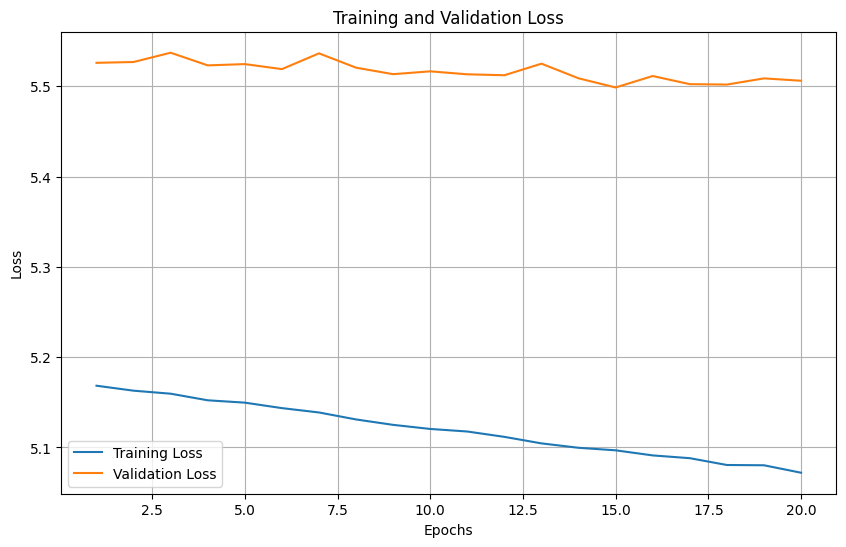

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
sample_eng_sentence = "<start> And by the night when it covers up <end>"

translated_to_urdu = translate_sentence(
    input_sentence=sample_eng_sentence,
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    translation_model=transformer,
    max_length=100
)

print("Translated to Urdu:", translated_to_urdu)


Input tensor: [[8907    3 1420   15  188    8  620  148   89 3510  157  778 8907    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Translated tokens: [4, 7730, 7730, 7730, 7730, 7730, 17, 15, 15, 15, 15, 15, 32, 3, 7730, 3]
Translated to Urdu: <end>      و اور اور اور اور اور تم<start> <start>


In [41]:
sample_eng_sentence = "<start> So , never should you be strict with any orphan <end>"

translated_to_urdu = translate_sentence(
    input_sentence=sample_eng_sentence,
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    translation_model=transformer,
    max_length=100
)

print("Translated to Urdu:", translated_to_urdu)


Input tensor: [[8907    3 1420   92  599  450   31   39 5349   99  182 1752  778 8907
     4    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Translated tokens: [4, 7730, 7730, 20, 20, 6, 6, 6, 6, 6, 6, 32, 144, 134, 3, 7730, 3]
Translated to Urdu: <end>   کی کی ک ک ک ک ک ک تم یا اگر<start> <start>


In [45]:
sample_eng_sentence = "<start> In th name of allah <end>"

translated_to_urdu = translate_sentence(
    input_sentence=sample_eng_sentence,
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    translation_model=transformer,
    max_length=100
)

print("Translated to Urdu:", translated_to_urdu)


Input tensor: [[8907    3 1420   42  221 1417   28   56  778 8907    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Translated tokens: [4, 7730, 7730, 324, 20, 114, 6, 6, 6, 81, 3, 7730, 3]
Translated to Urdu: <end>   بڑی کی رب ک ک ک آپ<start> <start>


In [44]:
sample_eng_sentence = "<start> In the name of Allah. <end>"

translated_to_urdu = translate_sentence(
    input_sentence=sample_eng_sentence,
    input_sp_model=sp_eng,
    target_sp_model=sp_urdu,
    translation_model=transformer,
    max_length=50
)

print("Translated to Urdu:", translated_to_urdu)

Input tensor: [[8907    3 1420   42    8 1417   28   56  778 8907    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


InvalidArgumentError: Graph execution error:

Detected at node transformer_1/decoder__1/pos_emb_1_1/add defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,50,512] vs. [1,100,512]
	 [[{{node transformer_1/decoder__1/pos_emb_1_1/add}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_494157[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_494676]

In [ ]:
# Get the vocabulary size
vocab_size = sp_urdu.get_piece_size()

# Iterate through the vocabulary and print each token
for i in range(vocab_size):
    print(sp_urdu.id_to_piece(i))


In [36]:
class LSTM_Translation_Model(tf.keras.Model):
    def __init__(self, vocab_size_input, vocab_size_output, embedding_dim, lstm_units):
        super(LSTM_Translation_Model, self).__init__()

        # Encoder: Input Embedding -> LSTM -> Encoder Hidden State
        self.encoder_embedding = tf.keras.layers.Embedding(vocab_size_input, embedding_dim)
        self.encoder_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True)

        # Decoder: Output Embedding -> LSTM -> Dense (Softmax)
        self.decoder_embedding = tf.keras.layers.Embedding(vocab_size_output, embedding_dim)
        self.decoder_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.decoder_dense = tf.keras.layers.Dense(vocab_size_output, activation='softmax')

    def call(self, inputs):
        encoder_input, decoder_input = inputs  # Unpack the tuple
        
        # Encoder
        encoder_embedded = self.encoder_embedding(encoder_input)
        encoder_output, state_h, state_c = self.encoder_lstm(encoder_embedded)

        # Decoder
        decoder_embedded = self.decoder_embedding(decoder_input)
        decoder_output, _, _ = self.decoder_lstm(decoder_embedded, initial_state=[state_h, state_c])
        decoder_output = self.decoder_dense(decoder_output)

        return decoder_output

# Parameters
embedding_dim = 512
lstm_units = 512
vocab_size_input = eng_vocab_size  # Replace with your English vocab size
vocab_size_output = urdu_vocab_size  # Replace with your Urdu vocab size

# Initialize the model
lstm_translation_model = LSTM_Translation_Model(vocab_size_input, vocab_size_output, embedding_dim, lstm_units)

# Compile the model
lstm_translation_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_h=lstm_translation_model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.6200 - loss: 3.1644 - val_accuracy: 0.7887 - val_loss: 1.5272
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8339 - loss: 1.2321 - val_accuracy: 0.8963 - val_loss: 0.8346
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9122 - loss: 0.7020 - val_accuracy: 0.9340 - val_loss: 0.5526
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9423 - loss: 0.4692 - val_accuracy: 0.9539 - val_loss: 0.3886
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9608 - loss: 0.3181 - val_accuracy: 0.9678 - val_loss: 0.2819


In [37]:
import time
import numpy as np
import tensorflow as tf
from memory_profiler import memory_usage

# Function to calculate perplexity (lower is better)
def calculate_perplexity(model, dataset):
    total_loss = 0
    num_batches = 0
    for batch in dataset:
        inputs, targets = batch
        # Make predictions
        predictions = model(inputs, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions, from_logits=True)
        total_loss += tf.reduce_sum(loss)
        num_batches += 1
    avg_loss = total_loss / num_batches
    perplexity = np.exp(avg_loss)
    return perplexity

# Measure training time for LSTM (2 epochs)
start_time_lstm = time.time()
lstm_h = lstm_translation_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
end_time_lstm = time.time()
training_time_lstm = end_time_lstm - start_time_lstm

# Measure training time for Transformer (10 epochs)
start_time_transformer = time.time()
history = transformer.fit(train_dataset, epochs=10, validation_data=val_dataset)
end_time_transformer = time.time()
training_time_transformer = end_time_transformer - start_time_transformer

# Measure Memory Usage during Training for LSTM
def track_memory_usage_lstm():
    def wrapper():
        lstm_translation_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
    mem_usage_lstm = memory_usage(wrapper)
    return max(mem_usage_lstm)

memory_usage_lstm = track_memory_usage_lstm()

# Measure Memory Usage during Training for Transformer
def track_memory_usage_transformer():
    def wrapper():
        transformer.fit(train_dataset, epochs=10, validation_data=val_dataset)
    mem_usage_transformer = memory_usage(wrapper)
    return max(mem_usage_transformer)

memory_usage_transformer = track_memory_usage_transformer()

# Measure Inference Speed for LSTM
def inference_speed_lstm(model, val_dataset):
    start_time = time.time()
    for batch in val_dataset.take(10):  # Taking a subset of validation data for inference
        inputs, _ = batch
        model(inputs, training=False)
    end_time = time.time()
    return (end_time - start_time) / 10  # Average time per batch

inference_time_lstm = inference_speed_lstm(lstm_translation_model, val_dataset)

# Measure Inference Speed for Transformer
def inference_speed_transformer(model, val_dataset):
    start_time = time.time()
    for batch in val_dataset.take(10):  # Taking a subset of validation data for inference
        inputs, _ = batch
        model(inputs, training=False)
    end_time = time.time()
    return (end_time - start_time) / 10  # Average time per batch

inference_time_transformer = inference_speed_transformer(transformer, val_dataset)

# Calculate Perplexity for LSTM Model
perplexity_lstm = calculate_perplexity(lstm_translation_model, val_dataset)

# Calculate Perplexity for Transformer Model
perplexity_transformer = calculate_perplexity(transformer, val_dataset)

# Print out the comparison results
print(f"LSTM Training Time (2 epochs): {training_time_lstm:.2f} seconds")
print(f"Transformer Training Time (10 epochs): {training_time_transformer:.2f} seconds")
print(f"LSTM Memory Usage: {memory_usage_lstm:.2f} MB")
print(f"Transformer Memory Usage: {memory_usage_transformer:.2f} MB")
print(f"LSTM Inference Speed: {inference_time_lstm:.4f} seconds per batch")
print(f"Transformer Inference Speed: {inference_time_transformer:.4f} seconds per batch")
print(f"LSTM Perplexity: {perplexity_lstm:.2f}")
print(f"Transformer Perplexity: {perplexity_transformer:.2f}")

Epoch 1/2
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9722 - loss: 0.2287 - val_accuracy: 0.9767 - val_loss: 0.2121
Epoch 2/2
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9810 - loss: 0.1575 - val_accuracy: 0.9824 - val_loss: 0.1667
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 5.0293 - masked_accuracy: 0.1563 - val_loss: 5.4986 - val_masked_accuracy: 0.1452
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.0123 - masked_accuracy: 0.1590 - val_loss: 5.5056 - val_masked_accuracy: 0.1461
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 5.0266 - masked_accuracy: 0.1563 - val_loss: 5.5055 - val_masked_accuracy: 0.1429
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.0005 - masked_accuracy: 0.1600 - val_loss: 5.5082 - val_masked_accuracy: 0.1451
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 5.0174 - masked_accuracy: 0.1592 - val_loss: 5.5023 - val_masked_accuracy: 0.1425
Epoch 6/10
180/18

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9864 - loss: 0.1114 - val_accuracy: 0.9862 - val_loss: 0.1352
Epoch 2/2
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9909 - loss: 0.0753 - val_accuracy: 0.9886 - val_loss: 0.1141


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 4.9833 - masked_accuracy: 0.1602 - val_loss: 5.5024 - val_masked_accuracy: 0.1457
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 4.9773 - masked_accuracy: 0.1595 - val_loss: 5.4998 - val_masked_accuracy: 0.1461
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 4.9670 - masked_accuracy: 0.1611 - val_loss: 5.5036 - val_masked_accuracy: 0.1465
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 4.9805 - masked_accuracy: 0.1595 - val_loss: 5.4906 - val_masked_accuracy: 0.1481
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 4.9642 - masked_accuracy: 0.1604 - val_loss: 5.5035 - val_masked_accuracy: 0.1462
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - loss: 4.9584 - masked_accuracy: 0.1618 - val_loss: 5.5078 - val_masked_accuracy: 0.1471
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - loss: 4.9514 - masked_accuracy: 0.1635 - val_loss: 5.5016 - val_masked_ac

/tmp/ipykernel_30/3151321084.py:18: RuntimeWarning: overflow encountered in exp
  perplexity = np.exp(avg_loss)


LSTM Training Time (2 epochs): 28.75 seconds
Transformer Training Time (10 epochs): 220.62 seconds
LSTM Memory Usage: 3872.61 MB
Transformer Memory Usage: 3876.73 MB
LSTM Inference Speed: 0.0402 seconds per batch
Transformer Inference Speed: 0.3738 seconds per batch
LSTM Perplexity: inf
Transformer Perplexity: inf
